In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/face-mask-dataset/data/without_mask/without_mask_3248.jpg
/kaggle/input/face-mask-dataset/data/without_mask/without_mask_2803.jpg
/kaggle/input/face-mask-dataset/data/without_mask/without_mask_650.jpg
/kaggle/input/face-mask-dataset/data/without_mask/without_mask_2060.jpg
/kaggle/input/face-mask-dataset/data/without_mask/without_mask_559.jpg
/kaggle/input/face-mask-dataset/data/without_mask/without_mask_3273.jpg
/kaggle/input/face-mask-dataset/data/without_mask/without_mask_124.jpg
/kaggle/input/face-mask-dataset/data/without_mask/without_mask_1849.jpg
/kaggle/input/face-mask-dataset/data/without_mask/without_mask_139.jpg
/kaggle/input/face-mask-dataset/data/without_mask/without_mask_2137.jpg
/kaggle/input/face-mask-dataset/data/without_mask/without_mask_2438.jpg
/kaggle/input/face-mask-dataset/data/without_mask/without_mask_553.jpg
/kaggle/input/face-mask-dataset/data/without_mask/without_mask_2661.jpg
/kaggle/input/face-mask-dataset/data/without_mask/without_mask_966.jp

In [2]:
!pip install imutils

  Preparing metadata (setup.py) ... done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25838 sha256=860cc6c47214cd1be57babec4fc7f4b5efcf11459c9a4e11017a530f5193ccaf
  Stored in directory: /root/.cache/pip/wheels/85/cf/3a/e265e975a1e7c7e54eb3692d6aa4e2e7d6a3945d29da46f2d7
Successfully built imutils


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import tensorflow as tf
%matplotlib inline
import argparse

# **Visualizing the Images**

In [4]:
With_Mask_Image = Image.open("/kaggle/input/face-mask-dataset/data/with_mask/with_mask_1.jpg")
Without_Mask_Image = Image.open("/kaggle/input/face-mask-dataset/data/without_mask/without_mask_1012.jpg")

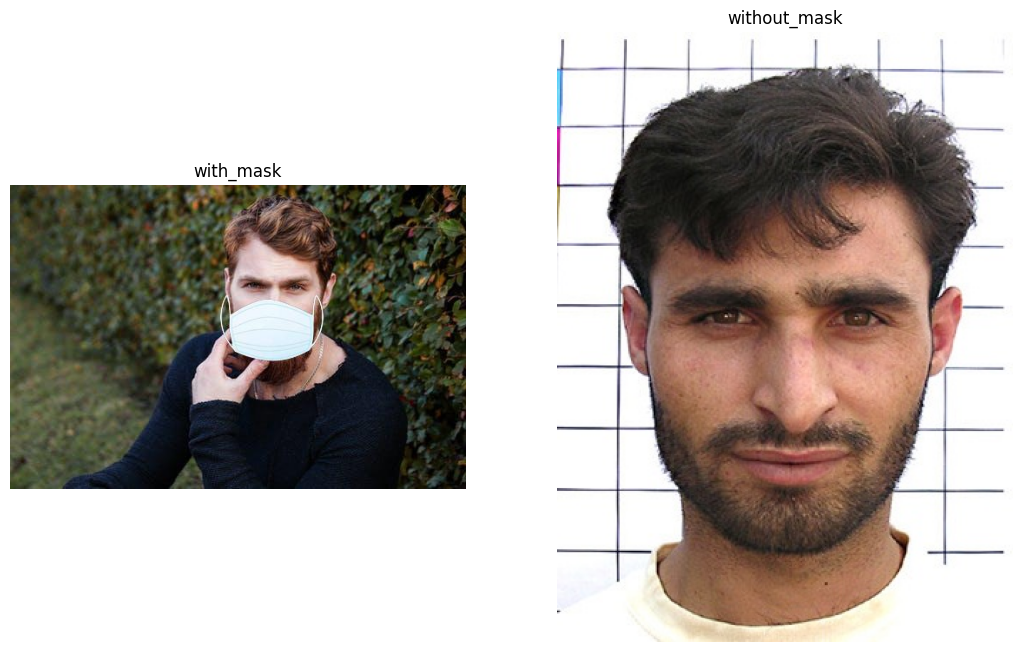

In [5]:
plt.figure(figsize=(20, 20))
i = 0
class_names = ["with_mask","without_mask"]
images = [With_Mask_Image,Without_Mask_Image]
for item in images:
  ax = plt.subplot(1, 3, i+1)
  plt.imshow(item)
  plt.title(class_names[i])
  plt.axis("off")
  i+=1

**We need to loop through the Images, Thus we will create an array to save all the images in**

In [6]:
ImagesWithMask = []
ImagesWithoutMask = []
for filename in os.listdir("/kaggle/input/face-mask-dataset/data/with_mask"):
    ImagesWithMask.append(filename)
    
for filename in os.listdir("/kaggle/input/face-mask-dataset/data/without_mask"):
    ImagesWithoutMask.append(filename)

In [7]:
#Size of the batches of data
BATCH_SIZE = 32
#Size to resize images
IMG_SIZE = (224, 224)
init_lr = 1e-4  # 0.0001
epochs = 10

**Now, we need to split the image and the labels**

In [8]:
Images = []
Labels = []

for img in ImagesWithMask:
    label = 'with_mask'
    Image = load_img('/kaggle/input/face-mask-dataset/data/with_mask/'+img,target_size=(224,224))
    Image = img_to_array(Image)
    Image = preprocess_input(Image)
    Images.append(Image)
    Labels.append(label)
    
for img in ImagesWithoutMask:
    label = 'without_mask'
    Image = load_img("/kaggle/input/face-mask-dataset/data/without_mask/"+img,target_size=(224,224))
    Image = img_to_array(Image)
    Image = preprocess_input(Image)
    Images.append(Image)
    Labels.append(label)


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [9]:
Images = np.array(Images, dtype="float32")
Labels = np.array(Labels)

In [10]:
lb = LabelBinarizer()
Labels = lb.fit_transform(Labels)
print("Text categories in number form: \n",Labels)
Labels = to_categorical(Labels)
print("One Hot Encoding: \n",Labels)

Text categories in number form: 
 [[0]
 [0]
 [0]
 ...
 [1]
 [1]
 [1]]
One Hot Encoding: 
 [[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


**We need to prepare the dataset for the model and need to split it to train and test**

In [11]:
(train_x,test_x,train_y,test_y) = train_test_split(Images, Labels, test_size = 0.20, stratify = Labels, random_state = 42)

In [12]:
Train_Generator = ImageDataGenerator(rotation_range = 20,zoom_range = 0.15,
                    width_shift_range = 0.2,height_shift_range = 0.2,
                    shear_range = 0.15,horizontal_flip = True,
                    fill_mode="nearest"
                  )

In [13]:
base_model = MobileNetV2(input_tensor = tf.keras.layers.Input(shape = (224,224,3)),
# base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(
    input_shape=(224,224,3),
    include_top=False,
    weights='imagenet',
    classifier_activation='softmax'
)

9406464/9406464 [==============================] - 0s 0us/step


In [14]:
base_model.output 

<KerasTensor: shape=(None, 7, 7, 1280) dtype=float32 (created by layer 'out_relu')>

In [15]:
headModel = base_model.output              # headModel input is Basemodel's output
headModel = tf.keras.layers.AveragePooling2D(pool_size = (7,7))(headModel)
headModel = tf.keras.layers.Flatten()(headModel)
headModel = tf.keras.layers.Dense(128, activation = 'relu')(headModel)
headModel = tf.keras.layers.Dropout(0.5)(headModel)
headModel = tf.keras.layers.Dense(2, activation = 'softmax')(headModel)

In [16]:
model = tf.keras.models.Model(inputs = base_model.input, outputs = headModel)
for layers in base_model.layers:
    base_model.trainable = False

In [17]:
opt = Adam(lr = init_lr, decay = init_lr/epochs)
model.compile(optimizer=opt, loss = 'binary_crossentropy',metrics = ['accuracy'])

/opt/conda/lib/python3.10/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [18]:
history = model.fit(Train_Generator.flow(train_x,train_y,batch_size=BATCH_SIZE),
                    steps_per_epoch = len(train_x)//BATCH_SIZE,
                    validation_data = (test_x,test_y),
                    validation_steps = len(test_x)//BATCH_SIZE,
                    epochs = epochs,
                    verbose = 1
                    )

Epoch 1/10
188/188 [==============================] - 232s 1s/step - loss: 0.3025 - accuracy: 0.8899 - val_loss: 0.0816 - val_accuracy: 0.9821
Epoch 2/10
188/188 [==============================] - 188s 996ms/step - loss: 0.0902 - accuracy: 0.9740
Epoch 3/10
188/188 [==============================] - 189s 1s/step - loss: 0.0699 - accuracy: 0.9797
Epoch 4/10
188/188 [==============================] - 189s 1s/step - loss: 0.0521 - accuracy: 0.9862
Epoch 5/10
188/188 [==============================] - 192s 1s/step - loss: 0.0471 - accuracy: 0.9857
Epoch 6/10
188/188 [==============================] - 189s 1s/step - loss: 0.0437 - accuracy: 0.9875
Epoch 7/10
188/188 [==============================] - 191s 1s/step - loss: 0.0421 - accuracy: 0.9877
Epoch 8/10
188/188 [==============================] - 190s 1s/step - loss: 0.0418 - accuracy: 0.9867
Epoch 9/10
188/188 [==============================] - 192s 1s/step - loss: 0.0346 - accuracy: 0.9895
Epoch 10/10
188/188 [=========================

In [19]:
loss, accuracy = model.evaluate(test_x, test_y)
print('Test accuracy =', accuracy)

48/48 [==============================] - 41s 847ms/step - loss: 0.0262 - accuracy: 0.9940
Test accuracy = 0.9940437078475952


In [20]:
model.save("model.h5")

In [21]:
mod = tf.keras.models.load_model('model.h5')

In [ ]:
idx = np.random.randint(0,test_x.shape[0])
pic = test_x[idx]
Ipic = np.expand_dims(pic,axis=0)
IFpic = mod.predict(Ipic)
predictions = np.argmax(IFpic)
print("The Prediction For This Image =",predictions)
print("The Actual Prediction For This Image =",test_y[idx])
fig,ax = plt.subplots()
ax.imshow(pic)
plt.imshow(pic)